In [ ]:
!pip install pandas
!pip install openpyxl
!pip install matplotlib
!pip install tensorflow matplotlib numpy==1.24.3 
!pip install scikit-learn
!pip install scipy==1.10.1

You should consider upgrading via the 'C:\Users\ALI\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\ALI\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\ALI\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [1]:
import os
import pandas as pd
import numpy as np

# Folder containing Excel files
folder_path = 'input/'

# Initialize lists for data
X_list = []
y_list = []

In [2]:
# Load the file using openpyxl to handle messy formatting and extract content textually
from openpyxl import load_workbook

# Specify the file path
file_path = 'input/LED_Matrix_2025_04_30_23_42_06.xlsx'

# Load workbook and the sheet
wb = load_workbook(file_path, data_only=True)
phys_sheet = wb['Physical_Setup']

# Read the entire column A as text (it contains all content of interest)
column_data = [row[0] for row in phys_sheet.iter_rows(min_row=1, max_col=1, values_only=True) if row[0] is not None]

# Find the start of the 13x15 grid (Graph Grid 13x15 (1 or 0))
grid_start_idx = -1
for i, val in enumerate(column_data):
    if "Graph Grid 13x15" in str(val):
        grid_start_idx = i + 3  # Skip header rows like "Row1:", "Column1:"
        break

# Extract 13x15 binary grid
grid_lines = column_data[grid_start_idx:grid_start_idx + 15]
grid_matrix = []
for line in grid_lines:
    digits = [int(x) for x in str(line).strip().split() if x in ('0', '1')]
    if len(digits) == 13:
        grid_matrix.append(digits)

# Also extract the 5x5 occupancy mask (bottom part, after the phrase "Grid occupancy of object")
occupancy_start = -1
for i, val in enumerate(column_data):
    if "Grid occupancy of object" in str(val):
        occupancy_start = i + 1
        break

occupancy_lines = column_data[occupancy_start:occupancy_start + 5]
occupancy_matrix = []
for line in occupancy_lines:
    digits = [int(cell) for cell in str(line).strip().split() if cell.isdigit()]
    if len(digits) == 5:
        occupancy_matrix.append(digits)

import numpy as np
grid_array = np.array(grid_matrix)
occupancy_array = np.array(occupancy_matrix)

grid_array.shape, occupancy_array.shape


FileNotFoundError: [Errno 2] No such file or directory: 'input/LED_Matrix_2025_04_30_23_42_06.xlsx'

In [6]:
def extract_X_y_from_excel_13x15(file_path):
    try:
        wb = load_workbook(file_path, data_only=True)

        # ---- Extract X from 'Average' ----
        avg_sheet = wb['Average']
        X = []
        for row in avg_sheet.iter_rows(min_row=2, max_row=26, min_col=2, max_col=26, values_only=True):
            X.append(list(row))
        X_array = np.array(X)
        if X_array.shape != (25, 25):
            raise ValueError(f"X shape incorrect: {X_array.shape}")

        # ---- Extract y from 'Physical_Setup' ----
        phys_sheet = wb['Physical_Setup']
        column_data = [row[0] for row in phys_sheet.iter_rows(min_row=1, max_col=1, values_only=True) if row[0] is not None]

        # Find grid start
        grid_start = -1
        for i, val in enumerate(column_data):
            if "Graph Grid 13x15" in str(val):
                grid_start = i + 3
                break

        # Parse up to 20 rows, pick only rows with 13 binary digits
        y = []
        for line in column_data[grid_start:grid_start + 20]:
            digits = [int(x) for x in str(line).strip().split() if x in ('0', '1')]
            if len(digits) == 13:
                y.append(digits)
        y_array = np.array(y)

        # Pad to (15, 13) if needed
        while y_array.shape[0] < 15:
            y_array = np.vstack([y_array, np.zeros((1, 13), dtype=int)])

        if y_array.shape != (15, 13):
            raise ValueError(f"y shape still incorrect after padding: {y_array.shape}")

        return X_array, y_array

    except Exception as e:
        print(f"Error in file {file_path}: {e}")
        return None, None



In [7]:
X, y = extract_X_y_from_excel_13x15('input/LED_Matrix_2025_04_30_23_42_06.xlsx')

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (25, 25)
y shape: (15, 13)


In [8]:
print("X values:\n", X)
print("y values:\n", y)


X values:
 [[443.472 452.938 441.772 439.7   446.016 429.066 448.362 446.736 370.228
  455.336 447.27  455.574 449.604 452.938 447.726 452.988 460.492 463.334
  460.426 461.756 454.768 468.254 467.012 467.81  465.256]
 [445.072 428.844 429.566 423.38  440.608 432.236 438.958 430.102 434.112
  446.762 441.776 437.776 455.778 456.156 453.286 447.238 466.234 461.73
  459.768 458.712 468.694 464.328 469.72  465.472 469.506]
 [441.066 420.38  417.382 415.588 429.092 437.088 428.928 419.746 423.274
  425.    429.18  426.768 426.844 443.602 452.548 446.22  449.564 465.36
  460.882 465.966 460.352 474.844 472.468 463.352 457.14 ]
 [443.09  429.5   423.414 413.67  420.654 443.998 432.266 396.622 417.28
  424.524 439.978 423.93  430.796 442.244 455.768 452.782 438.142 449.116
  452.926 448.732 464.336 458.862 469.594 459.246 467.488]
 [458.02  442.558 441.106 439.056 446.61  455.732 443.922 440.714 440.98
  452.076 462.9   449.168 442.048 454.294 462.024 458.584 450.412 457.87
  473.2   471.33  

In [9]:
import os
import numpy as np
from openpyxl import load_workbook

def extract_X_y_from_excel_13x15(file_path):
    try:
        wb = load_workbook(file_path, data_only=True)

        # --- Extract X from 'Average' sheet ---
        avg_sheet = wb['Average']
        X = []
        for row in avg_sheet.iter_rows(min_row=2, max_row=26, min_col=2, max_col=26, values_only=True):
            X.append(list(row))
        X_array = np.array(X)
        if X_array.shape != (25, 25):
            raise ValueError(f"X shape incorrect: {X_array.shape}")

        # --- Extract y from 'Physical_Setup' ---
        phys_sheet = wb['Physical_Setup']
        column_data = [row[0] for row in phys_sheet.iter_rows(min_row=1, max_col=1, values_only=True) if row[0] is not None]

        grid_start = -1
        for i, val in enumerate(column_data):
            if "Graph Grid 13x15" in str(val):
                grid_start = i + 3
                break

        y = []
        for line in column_data[grid_start:grid_start + 20]:
            digits = [int(x) for x in str(line).strip().split() if x in ('0', '1')]
            if len(digits) == 13:
                y.append(digits)
        y_array = np.array(y)

        # Pad y to (15, 13)
        while y_array.shape[0] < 15:
            y_array = np.vstack([y_array, np.zeros((1, 13), dtype=int)])

        if y_array.shape != (15, 13):
            raise ValueError(f"y shape still incorrect after padding: {y_array.shape}")

        return X_array, y_array

    except Exception as e:
        print(f"[ERROR] {file_path}: {e}")
        return None, None


# ---- Loop over all files in 'input/' folder ----
folder_path = 'input'
X_list = []
y_list = []

for file in os.listdir(folder_path):
    if file.endswith('.xlsx'):
        path = os.path.join(folder_path, file)
        X, y = extract_X_y_from_excel_13x15(path)
        if X is not None and y is not None:
            X_list.append(X)
            y_list.append(y)

# ---- Convert to numpy arrays and save ----
X_all = np.array(X_list)
y_all = np.array(y_list)

print(f"✅ Extracted {len(X_all)} samples.")
np.savez('led_dataset_13x15.npz', X=X_all, y=y_all)


[ERROR] input\~$LED_Matrix_2025_02_24_22_52_37.xlsx: File is not a zip file
[ERROR] input\~$LED_Matrix_2025_02_24_23_24_01.xlsx: File is not a zip file
✅ Extracted 111 samples.


In [10]:
data = np.load('led_dataset_13x15.npz')
X = data['X']  # shape (n_samples, 25, 25)
y = data['y']  # shape (n_samples, 15, 13)


In [11]:
import numpy as np

# Load from previously saved .npz
data = np.load('led_dataset_13x15.npz')
X_all = data['X']  # shape: (n_samples, 25, 25)
y_all = data['y']  # shape: (n_samples, 15, 13)

# --- Step 1: Flatten ---
X_flat = X_all.reshape(len(X_all), -1)  # shape: (n_samples, 625)
y_flat = y_all.reshape(len(y_all), -1)  # shape: (n_samples, 195)

# --- Step 2: Validate ---
print("✅ Data loaded and flattened")
print("X_all shape (original):", X_all.shape)
print("y_all shape (original):", y_all.shape)
print("X_flat shape:", X_flat.shape)
print("y_flat shape:", y_flat.shape)

# Optional: check a few values
print("\nSample X[0][:10]:", X_flat[0][:10])
print("Sample y[0][:13]:", y_flat[0][:13])

# --- Step 3: Save flattened data ---
np.savez('led_dataset_flat.npz', X=X_flat, y=y_flat)
print("\n✅ Saved flattened data to 'led_dataset_flat.npz'")


✅ Data loaded and flattened
X_all shape (original): (111, 25, 25)
y_all shape (original): (111, 15, 13)
X_flat shape: (111, 625)
y_flat shape: (111, 195)

Sample X[0][:10]: [453.614 444.164 437.436 436.592 448.35  438.836 443.742 442.118 432.078
 447.62 ]
Sample y[0][:13]: [0 0 0 0 0 0 0 0 0 0 0 0 0]

✅ Saved flattened data to 'led_dataset_flat.npz'


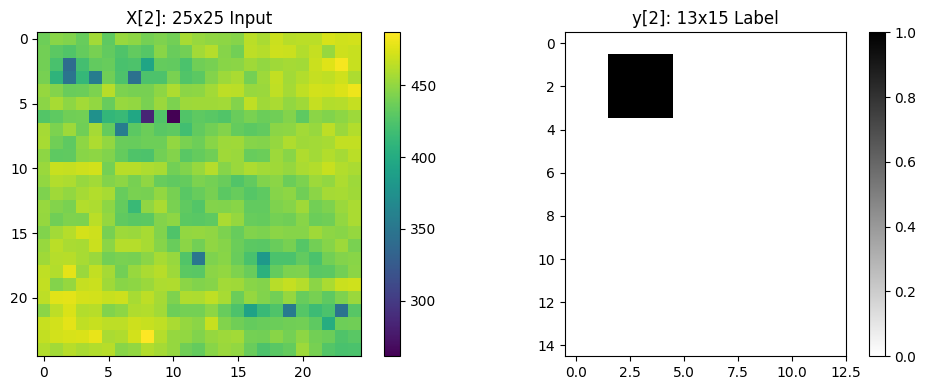

In [12]:
import matplotlib.pyplot as plt

# Show the first sample
i = 2  # or change to any index

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(X_all[i], cmap='viridis')
plt.title("X[{}]: 25x25 Input".format(i))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(y_all[i], cmap='binary')
plt.title("y[{}]: 13x15 Label".format(i))
plt.colorbar()

plt.tight_layout()
plt.show()


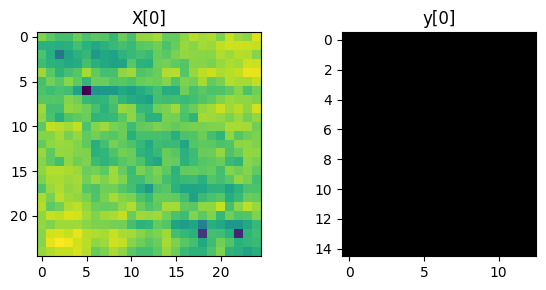

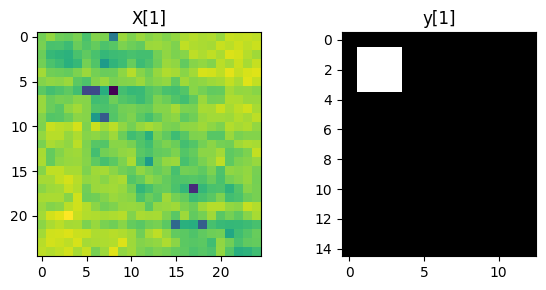

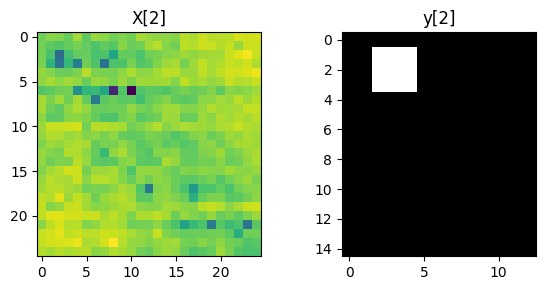

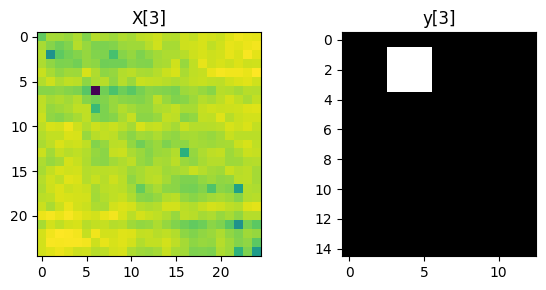

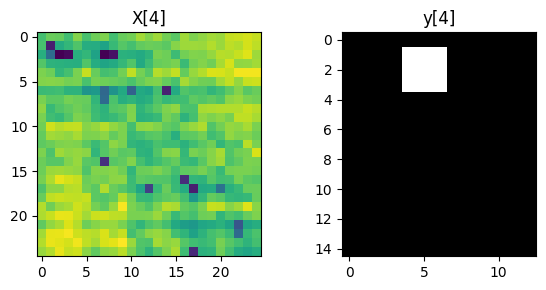

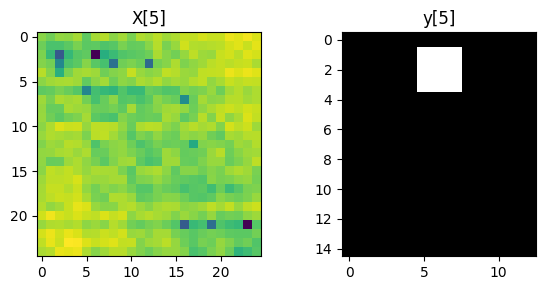

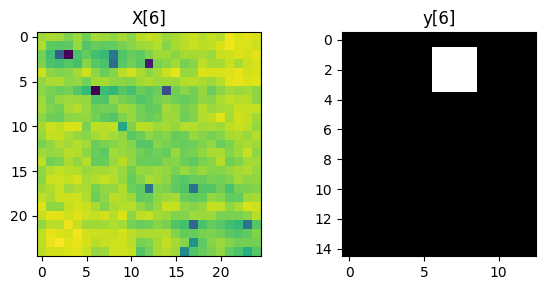

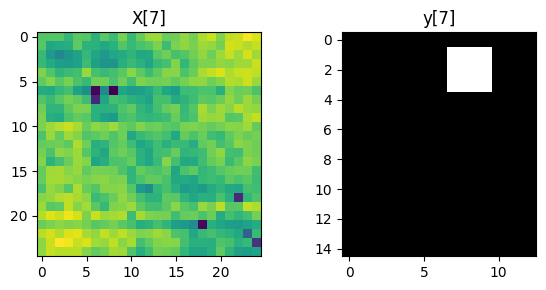

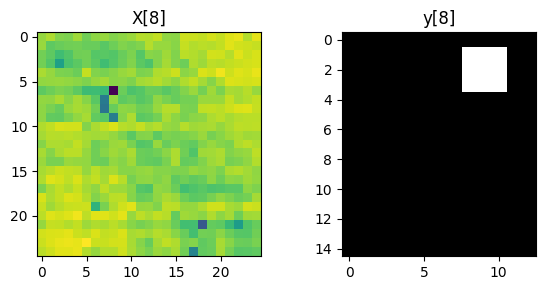

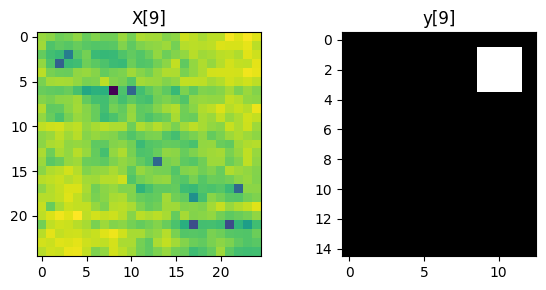

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Load
data = np.load('led_dataset_13x15.npz')
X_all = data['X'][..., np.newaxis].astype('float32')  # (n, 25, 25, 1)
y_all = data['y'][..., np.newaxis].astype('float32')  # (n, 15, 13, 1)

# Normalize input
X_all /= 500.0

# Sanity check
for i in range(10):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(X_all[i, :, :, 0], cmap='viridis')
    plt.title("X[{}]".format(i))

    plt.subplot(1, 2, 2)
    plt.imshow(y_all[i, :, :, 0], cmap='gray')
    plt.title("y[{}]".format(i))
    plt.tight_layout()
    plt.show()


In [23]:
import tensorflow as tf

# Shuffle + split
dataset_size = X_all.shape[0]
indices = tf.random.shuffle(tf.range(dataset_size))
split = int(0.8 * dataset_size)

X_train = tf.gather(X_all, indices[:split])
X_test  = tf.gather(X_all, indices[split:])
y_train = tf.gather(y_all, indices[:split])
y_test  = tf.gather(y_all, indices[split:])

# CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(25, 25, 1)),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(15 * 13, activation='sigmoid'),
    tf.keras.layers.Reshape((15, 13, 1))
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f}")


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.7033 - loss: 0.5837 - val_accuracy: 0.9333 - val_loss: 0.2442
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9351 - loss: 0.2643 - val_accuracy: 0.9538 - val_loss: 0.1985
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9514 - loss: 0.2194 - val_accuracy: 0.9538 - val_loss: 0.2019
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9487 - loss: 0.2000 - val_accuracy: 0.9538 - val_loss: 0.2308
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9516 - loss: 0.1958 - val_accuracy: 0.9538 - val_loss: 0.1928
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9532 - loss: 0.1956 - val_accuracy: 0.9538 - val_loss: 0.1904
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9538 - loss: 0.1871 - val_accuracy: 0.9538 - val_loss: 0.2096
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9546 - loss: 0.1794 - val_accuracy: 0.9538 - val_loss: 0.2072


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


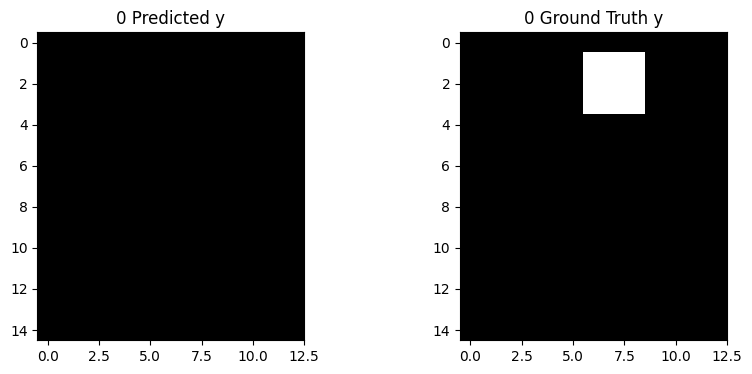

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


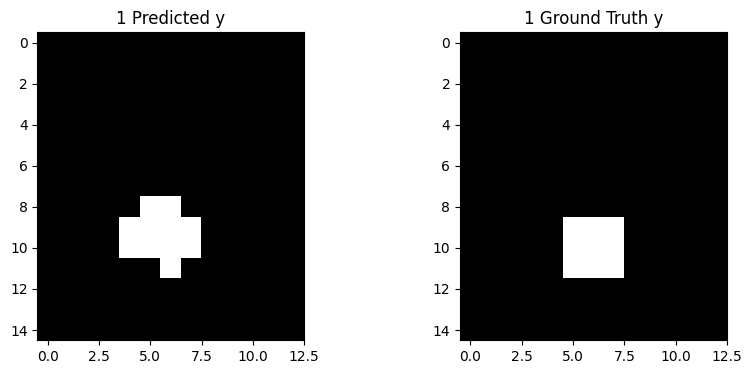

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


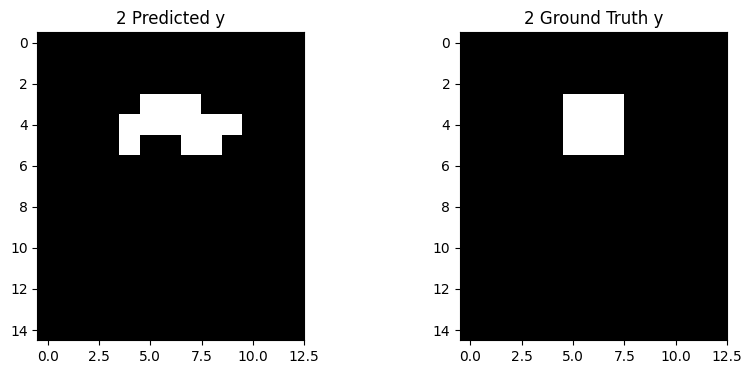

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


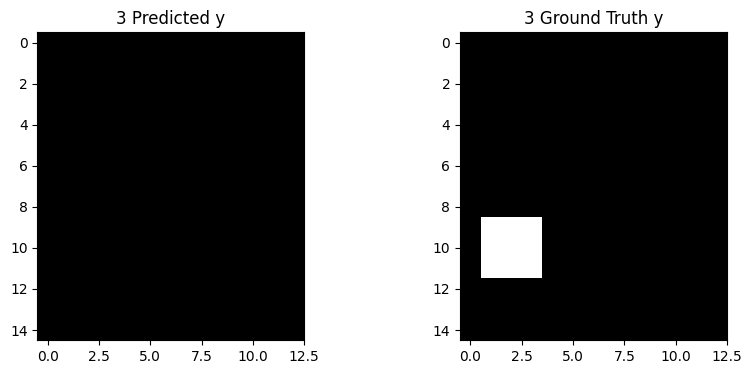

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


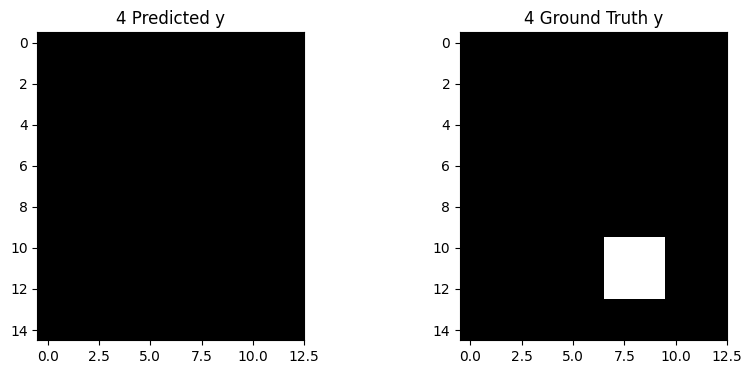

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


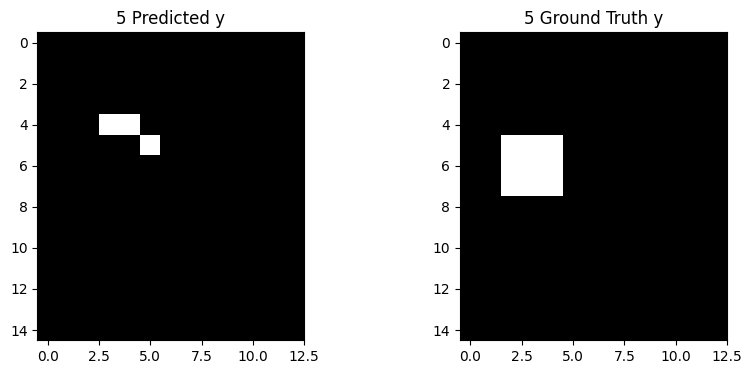

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


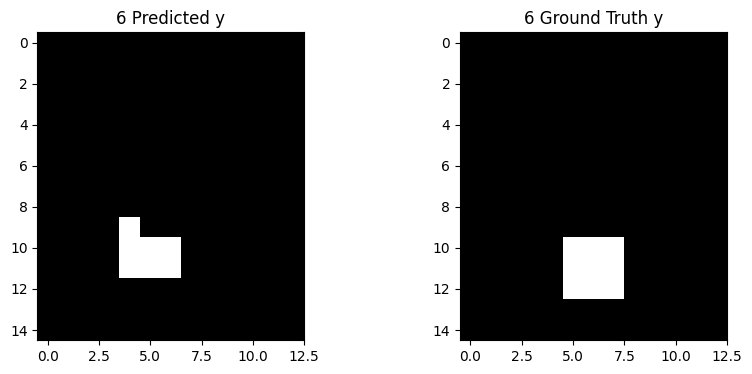

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


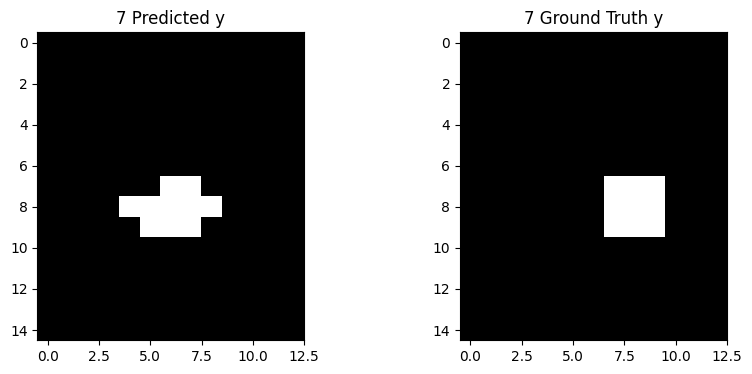

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


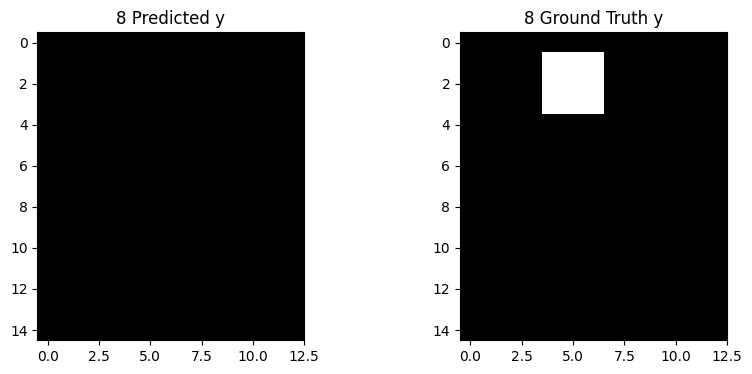

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


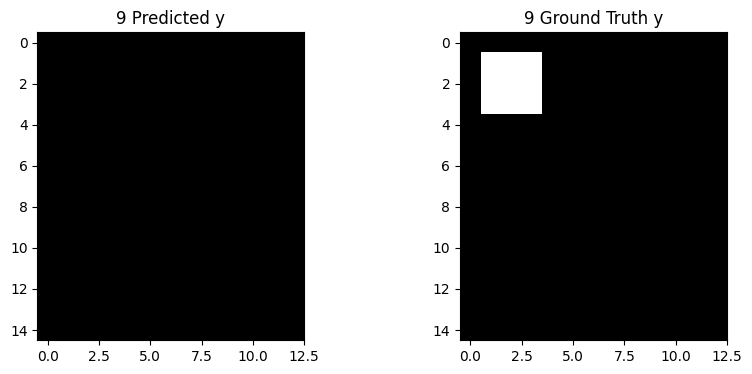

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


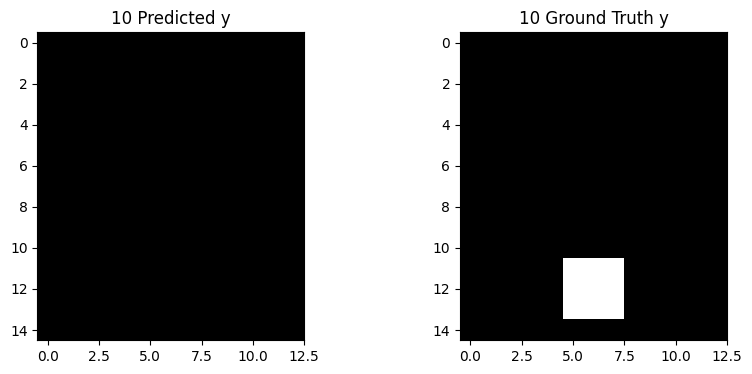

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


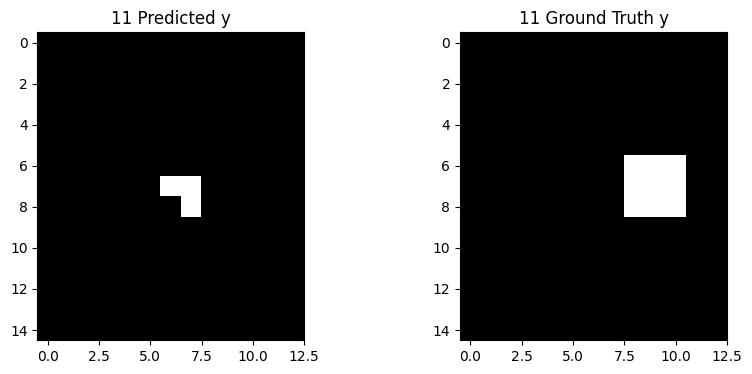

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


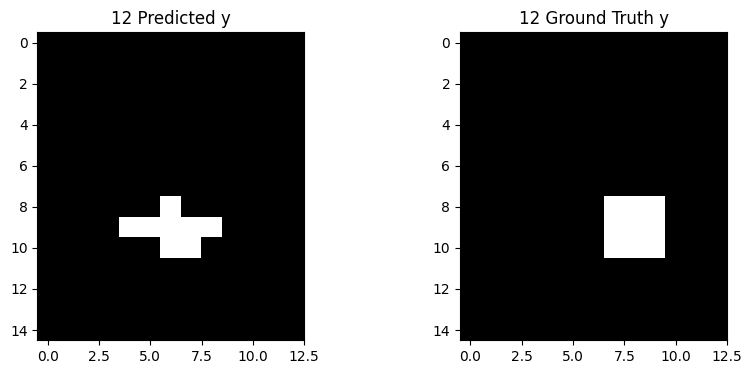

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


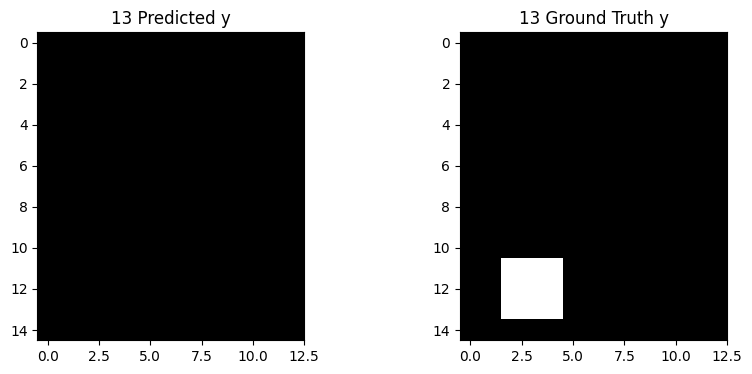

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


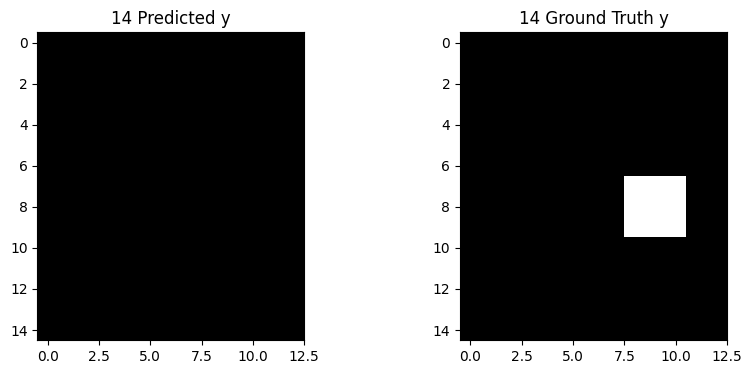

In [37]:
# Show one prediction
i = 4
for i in range (0,15):
    pred = model.predict(X_test[i:i+1])[0, ..., 0]
    true = y_test[i, ..., 0]
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(pred > 0.4, cmap='gray')
    plt.title(f"{i} Predicted y")
    
    plt.subplot(1, 2, 2)
    plt.imshow(true, cmap='gray')
    plt.title(f"{i} Ground Truth y")
    plt.show()
